# Cell 0 - Accumulation Signal Sandbox
Explore alternate short-signal formulas using daily_metrics data (read-only). No database writes.

In [1]:
# Cell 1 - Imports and Configuration
from pathlib import Path
import sys

import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

project_root = Path.cwd()
if (project_root / 'darkpool_analysis').exists():
    sys.path.insert(0, str(project_root))
elif (project_root.parent / 'darkpool_analysis').exists():
    sys.path.insert(0, str(project_root.parent))
elif (project_root.parent.parent / 'darkpool_analysis').exists():
    sys.path.insert(0, str(project_root.parent.parent))

from darkpool_analysis.config import load_config

config = load_config()

TICKER = 'PLTR'
START_DATE = '2025-11-18'
END_DATE = '2025-12-31'
DB_PATH = config.db_path

# Buy/Sell signal mode
BUY_SELL_SIGNAL = 'Rolling_Zscore'  # 'Mean_Threshold' or 'Rolling_Zscore'

# Median-threshold settings
THRESHOLD_K = 1.0
THRESHOLD_K_NEG = 1.3

# Rolling Z-score settings (used when BUY_SELL_SIGNAL = 'Rolling_Zscore')
ROLLING_LOOKBACK_DAYS = 0  # extra history (days) to fetch for rolling calcs
ROLLING_WINDOW_DAYS = 60
ZSCORE_K_BUY = 1.8
ZSCORE_K_SELL = 1.5
ZSCORE_MIN_PERIODS = 0  # defaults to ROLLING_WINDOW_DAYS

# Rolling mean line settings (used when BUY_SELL_SIGNAL = 'Rolling_Zscore')
ROLLING_MEAN_WINDOW_DAYS = ROLLING_WINDOW_DAYS
ROLLING_MEAN_SHIFT_DAYS = 1  # use prior days for forward-valid mean

# Text scaling for 30 days
AUTO_TEXT_SCALE = True  # scale text with figure width
BASE_FIG_WIDTH = 12.0
TEXT_SCALE_MIN = 1.0
TEXT_SCALE_MAX = 3.5
TEXT_SCALE_POWER = 6  # exponent for width-based scaling

# # Text scaling for 1 year
# AUTO_TEXT_SCALE = True  # scale text with figure width
# BASE_FIG_WIDTH = 12.0
# TEXT_SCALE_MIN = 1.0
# TEXT_SCALE_MAX = 3.5
# TEXT_SCALE_POWER = 6  # exponent for width-based scaling

# X-axis labeling
MAX_X_LABELS = 90  # keep all labels up to this count

# Figure sizing
FIG_HEIGHT_RATIO = 1.0  # height = width * ratio
FIG_DPI = 100
FIGSIZE_PX = None  # None, or (width_px, height_px) to override






In [2]:
# Cell 2 - Styling Constants and Helper Functions
import matplotlib.dates as mdates
import math
from scipy.interpolate import PchipInterpolator

COLORS = {
    'background': '#0f0f10',
    'panel_bg': '#141416',
    'text': '#e6e6e6',
    'text_muted': '#8b8b8b',
    'grid': '#2a2a2d',
    'white': '#ffffff',
    'green': '#00ff88',
    'red': '#ff6b6b',
    'yellow': '#ffd700',
    'cyan': '#00d4ff',
    'orange': '#ff9f43',
    'purple': '#b026ff',
    'neutral': '#6b6b6b',
    'blue': '#4aa3ff',
}
GRID_ALPHA = 0.18
OHLC_LINE_WIDTH = 1.2


def _compute_fig_width(day_count):
    if day_count <= 0:
        return 12.0
    buckets = int(np.ceil(day_count / 50))
    return 12.0 * max(1, buckets)


def _apply_axis_style(ax):
    scale = globals().get('TEXT_SCALE', 1.0)
    ax.set_facecolor(COLORS['panel_bg'])
    ax.tick_params(colors=COLORS['text'], labelsize=9 * scale)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(COLORS['grid'])
    ax.spines['bottom'].set_color(COLORS['grid'])
    ax.grid(True, alpha=GRID_ALPHA, color=COLORS['grid'], linestyle='--')


def _apply_accum_axis_style(ax):
    scale = globals().get('TEXT_SCALE', 1.0)
    ax.set_facecolor(COLORS['panel_bg'])
    ax.tick_params(colors=COLORS['text'], labelsize=9 * scale)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(COLORS['grid'])
    ax.spines['bottom'].set_color(COLORS['grid'])
    ax.grid(True, axis='y', alpha=GRID_ALPHA, color=COLORS['grid'], linestyle='-')
    ax.grid(False, axis='x')


def _format_plain_int(value):
    if pd.isna(value):
        return 'NA'
    return f'{value:,.0f}'.replace(',', '')


def _plot_smooth_line(ax, x_values, values, color, valid_mask, linewidth=1.0, alpha=0.7, zorder=3, linestyle='-'):
    """Plot a smooth PCHIP-interpolated line through valid data points."""
    mask = np.asarray(valid_mask)
    if mask.sum() >= 3:
        valid_x = x_values[mask]
        valid_values = values[mask]

        if pd.api.types.is_datetime64_any_dtype(valid_x):
            x_nums = mdates.date2num(pd.to_datetime(valid_x))
            x_dense = np.linspace(x_nums.min(), x_nums.max(), 150)
            x_smooth = np.unique(np.concatenate([x_nums, x_dense]))
            interp = PchipInterpolator(x_nums, np.asarray(valid_values, dtype=float))
            y_smooth = interp(x_smooth)
            x_plot = mdates.num2date(x_smooth)
        else:
            x_nums = np.asarray(valid_x, dtype=float)
            x_dense = np.linspace(x_nums.min(), x_nums.max(), 150)
            x_smooth = np.unique(np.concatenate([x_nums, x_dense]))
            interp = PchipInterpolator(x_nums, np.asarray(valid_values, dtype=float))
            y_smooth = interp(x_smooth)
            x_plot = x_smooth

        ax.plot(
            x_plot,
            y_smooth,
            color=color,
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder,
            linestyle=linestyle,
        )
    else:
        ax.plot(
            x_values[mask],
            values[mask],
            color=color,
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder,
            linestyle=linestyle,
        )


def _nice_volume_ticks(max_val, target_ticks=6):
    if max_val is None or max_val <= 0 or not np.isfinite(max_val):
        return np.array([0.0, 1.0])
    raw_step = max_val / max(target_ticks - 1, 1)
    magnitude = 10 ** int(math.floor(math.log10(raw_step)))
    while raw_step < magnitude:
        magnitude /= 10
    steps = [1, 2, 5, 10]
    step = steps[0] * magnitude
    for s in steps:
        candidate = s * magnitude
        if candidate <= raw_step:
            step = candidate
    top = math.ceil(max_val / step) * step
    return np.arange(0, top + step, step)


def _plot_ohlc_bars(ax, df_ohlc, x_indices):
    """Plot OHLC bars matching plotter_chart.py style."""
    bar_width = 0.6
    half_width = bar_width / 2

    for xi, (_, row) in zip(x_indices, df_ohlc.iterrows()):
        open_ = row['open']
        high = row['high']
        low = row['low']
        close = row['close']
        if pd.isna(open_) or pd.isna(close) or pd.isna(high) or pd.isna(low):
            continue
        color = COLORS['blue'] if close >= open_ else COLORS['orange']
        ax.vlines(xi, low, high, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)
        ax.hlines(open_, xi - half_width, xi, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)
        ax.hlines(close, xi, xi + half_width, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)





In [3]:
# Cell 3 - Data Loading and Processing
query_start_date = START_DATE
if BUY_SELL_SIGNAL == 'Rolling_Zscore' and ROLLING_LOOKBACK_DAYS and int(ROLLING_LOOKBACK_DAYS) > 0:
    query_start_date = (pd.to_datetime(START_DATE) - pd.Timedelta(days=int(ROLLING_LOOKBACK_DAYS))).strftime('%Y-%m-%d')

query = '''
    SELECT
        date,
        symbol,
        short_buy_volume,
        short_sell_volume,
        short_buy_sell_ratio,
        short_buy_sell_ratio_z,
        lit_buy_volume,
        lit_sell_volume,
        lit_flow_imbalance,
        lit_flow_imbalance_z,
        return_z,
        otc_participation_z,
        confidence
    FROM daily_metrics
    WHERE symbol = ? AND date BETWEEN ? AND ?
    ORDER BY date
'''

ohlc_query = '''
    SELECT
        trade_date AS date,
        open,
        high,
        low,
        close,
        volume
    FROM polygon_daily_agg_raw
    WHERE symbol = ? AND trade_date BETWEEN ? AND ?
    ORDER BY trade_date
'''

with duckdb.connect(str(DB_PATH), read_only=True) as conn:
    df = conn.execute(query, [TICKER.upper(), query_start_date, END_DATE]).df()
    df_ohlc = conn.execute(ohlc_query, [TICKER.upper(), query_start_date, END_DATE]).df()

if df.empty:
    raise ValueError(f'No data found for {TICKER} between {START_DATE} and {END_DATE}.')

df['date'] = pd.to_datetime(df['date'])
if 'short_buy_volume' in df.columns:
    df['short_buy_volume'] = pd.to_numeric(df['short_buy_volume'], errors='coerce')

# Process OHLC data
if not df_ohlc.empty:
    df_ohlc['date'] = pd.to_datetime(df_ohlc['date'])
    for col in ['open', 'high', 'low', 'close', 'volume']:
        if col in df_ohlc.columns:
            df_ohlc[col] = pd.to_numeric(df_ohlc[col], errors='coerce')
    # Merge OHLC with metrics on date
    df = df.merge(df_ohlc, on='date', how='left')
else:
    df['open'] = np.nan
    df['high'] = np.nan
    df['low'] = np.nan
    df['close'] = np.nan
    df['volume'] = np.nan

df['finra_buy_volume'] = df['short_buy_volume']


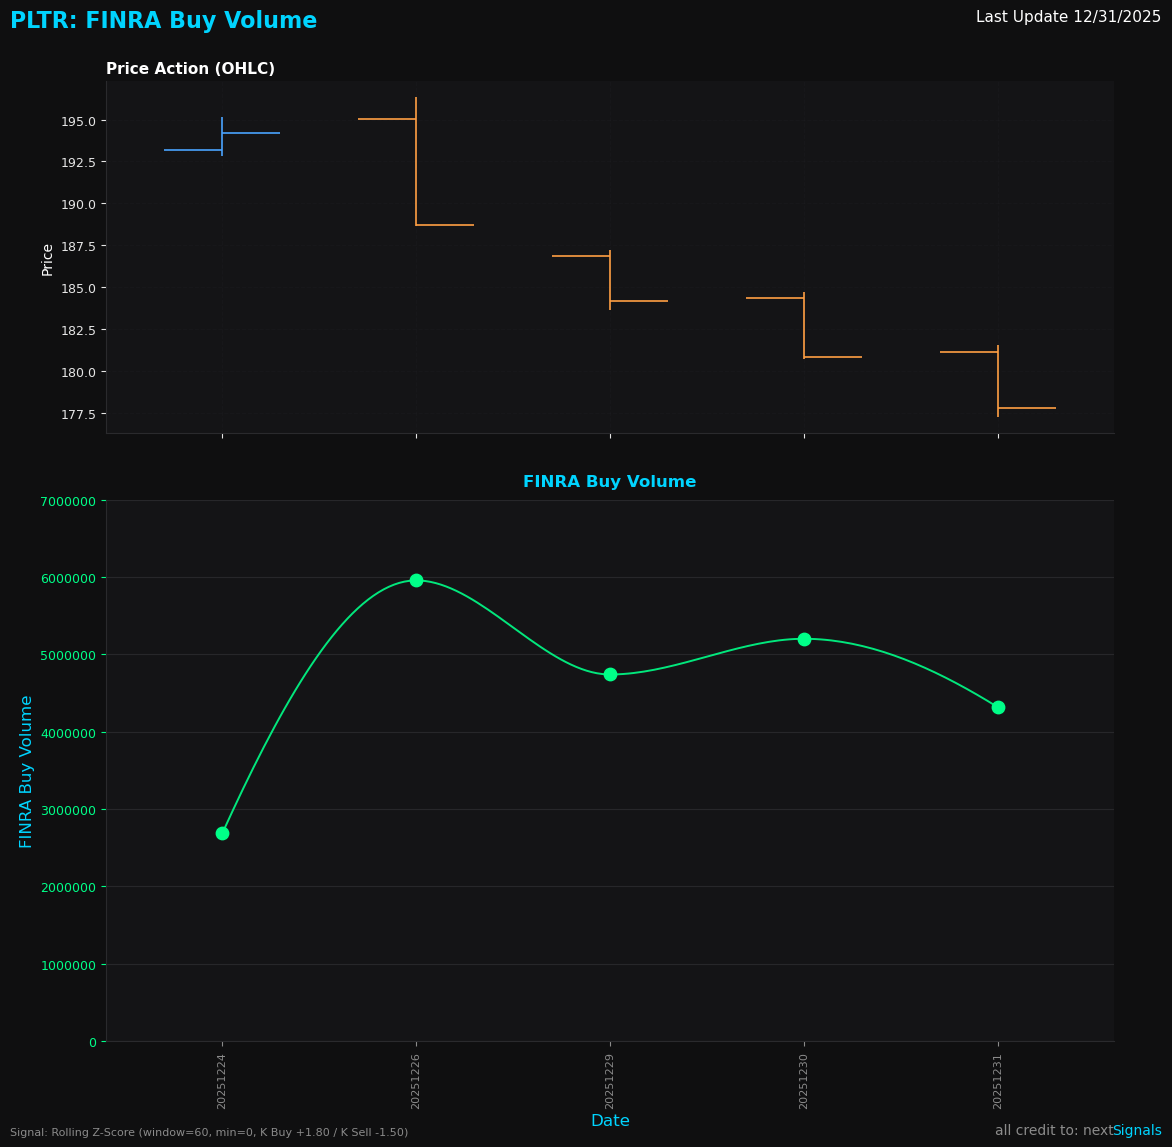

In [4]:
# Cell 4 - Two-Panel Plot (OHLC + Volume-Weighted Accumulation)
plt.style.use('dark_background')

full_df = df.sort_values('date').copy()
market_mask = full_df['close'].notna()
full_df = full_df.loc[market_mask].copy()
if full_df.empty:
    raise ValueError('No market days with OHLC data in the selected range.')
plot_start = pd.to_datetime(START_DATE)
plot_end = pd.to_datetime(END_DATE)
plot_df = full_df[(full_df['date'] >= plot_start) & (full_df['date'] <= plot_end)].copy()
plot_df = plot_df.reset_index(drop=True)
if plot_df.empty:
    raise ValueError('No market days with OHLC data in the selected range.')
if 'THRESHOLD_K_NEG' not in globals():
    THRESHOLD_K_NEG = THRESHOLD_K
x_labels = plot_df['date'].dt.strftime('%Y%m%d').tolist()
if 'finra_buy_volume' not in plot_df.columns:
    raise ValueError('finra_buy_volume missing from dataset.')
full_df['vw_accum'] = pd.to_numeric(full_df['finra_buy_volume'], errors='coerce')
accum_series = plot_df['finra_buy_volume']
if accum_series.isna().all():
    raise ValueError('finra_buy_volume is empty for the selected range.')
plot_df['vw_accum'] = pd.to_numeric(plot_df['finra_buy_volume'], errors='coerce')
if not plot_df['vw_accum'].equals(plot_df['finra_buy_volume']):
    raise ValueError('Panel 2 is not plotting finra_buy_volume.')

fig_width = _compute_fig_width(len(plot_df))
fig_height = fig_width * FIG_HEIGHT_RATIO
FIGSIZE = (fig_width, fig_height)
if FIGSIZE_PX is not None:
    fig_width = FIGSIZE_PX[0] / FIG_DPI
    fig_height = FIGSIZE_PX[1] / FIG_DPI
    FIGSIZE = (fig_width, fig_height)
text_scale = 1.0
if AUTO_TEXT_SCALE:
    base_width = float(BASE_FIG_WIDTH)
    if base_width > 0:
        text_scale = (fig_width / base_width) ** TEXT_SCALE_POWER
    text_scale = max(TEXT_SCALE_MIN, min(TEXT_SCALE_MAX, text_scale))
TEXT_SCALE = text_scale

fig = plt.figure(figsize=FIGSIZE)
fig.patch.set_facecolor(COLORS['background'])

# Layout tuned to keep panel 2 proportions close to the reference image
height_ratios = [1.3, 2]
fig_gs = fig.add_gridspec(
    2, 1,
    height_ratios=height_ratios,
    hspace=0.15,
    left=0.1,
    right=0.94,
    top=0.9,
    bottom=0.1,
)

ax_price = fig.add_subplot(fig_gs[0])
ax_accum = fig.add_subplot(fig_gs[1], sharex=ax_price)

# Panel 1: OHLC bar chart (plotter_chart.py styling)
_apply_axis_style(ax_price)
x_vals = np.arange(len(plot_df))
_plot_ohlc_bars(ax_price, plot_df, x_vals)
ax_price.set_ylabel('Price', color=COLORS['white'], fontsize=10 * text_scale)
ax_price.set_title('Price Action (OHLC)', color=COLORS['white'], fontsize=11 * text_scale, fontweight='bold', loc='left')
ax_price.tick_params(axis='x', labelbottom=False)
if len(x_vals) > 0:
    pad = 0.6
    ax_price.set_xlim(x_vals.min() - pad, x_vals.max() + pad)

# Panel 2: Volume-Weighted Accumulation (match attached style)
_apply_accum_axis_style(ax_accum)
accum = plot_df['vw_accum']
full_accum_series = full_df.set_index('date')['vw_accum']
full_valid_mask = ~full_accum_series.isna()
plot_dates = plot_df['date']
valid_mask = ~accum.isna()

def _compute_signal_indices(accum_series, valid_mask_series, full_accum_series=None, full_valid_mask=None, plot_dates=None):
    if BUY_SELL_SIGNAL == 'Mean_Threshold':
        mean_val = accum_series[valid_mask_series].mean()
        std_val = accum_series[valid_mask_series].std(ddof=0)

        pos_threshold = mean_val + (THRESHOLD_K * std_val if std_val and std_val > 0 else 0.0)
        pos_idx = accum_series[valid_mask_series][accum_series[valid_mask_series] >= pos_threshold].index
        if len(pos_idx) == 0:
            top_n = min(5, len(accum_series[valid_mask_series]))
            pos_idx = accum_series[valid_mask_series].nlargest(top_n).index

        neg_threshold = mean_val - (THRESHOLD_K_NEG * std_val if std_val and std_val > 0 else 0.0)
        neg_idx = accum_series[valid_mask_series][accum_series[valid_mask_series] <= neg_threshold].index
        if len(neg_idx) == 0:
            bottom_n = min(5, len(accum_series[valid_mask_series]))
            neg_idx = accum_series[valid_mask_series].nsmallest(bottom_n).index

        return pos_idx, neg_idx, mean_val, None

    if BUY_SELL_SIGNAL == 'Rolling_Zscore':
        base_series = full_accum_series if full_accum_series is not None else accum_series
        base_valid = full_valid_mask if full_valid_mask is not None else valid_mask_series
        window = int(ROLLING_WINDOW_DAYS)
        min_periods = window if ZSCORE_MIN_PERIODS is None else int(ZSCORE_MIN_PERIODS)
        prior = base_series.shift(1)
        rolling_mean = prior.rolling(window=window, min_periods=min_periods).mean()
        rolling_std = prior.rolling(window=window, min_periods=min_periods).std(ddof=0)
        z_scores = (base_series - rolling_mean) / rolling_std
        ok_mask = base_valid & rolling_mean.notna() & rolling_std.notna() & (rolling_std > 0)
        pos_mask = ok_mask & (z_scores >= ZSCORE_K_BUY)
        neg_mask = ok_mask & (z_scores <= -ZSCORE_K_SELL)
        pos_dates = base_series[pos_mask].index
        neg_dates = base_series[neg_mask].index
        if plot_dates is not None:
            pos_idx = plot_dates.index[plot_dates.isin(pos_dates)]
            neg_idx = plot_dates.index[plot_dates.isin(neg_dates)]
        else:
            pos_idx = pos_dates
            neg_idx = neg_dates
        return pos_idx, neg_idx, None, rolling_mean

    raise ValueError(f"Unknown BUY_SELL_SIGNAL mode: {BUY_SELL_SIGNAL}")

if valid_mask.any():
    _plot_smooth_line(
        ax_accum,
        x_vals,
        accum,
        COLORS['green'],
        valid_mask,
        linewidth=1.4,
        alpha=0.9,
        zorder=3,
    )
    ax_accum.scatter(
        x_vals[valid_mask],
        accum.loc[valid_mask],
        color=COLORS['green'],
        s=80,
        zorder=4,
    )

if valid_mask.any():
    max_val = accum[valid_mask].max()
else:
    max_val = 1.0

if pd.isna(max_val) or max_val <= 0:
    max_val = 1.0

y_min = 0.0
padded_max = max_val * 1.1
y_ticks = _nice_volume_ticks(padded_max)
y_max = float(y_ticks[-1])
ax_accum.set_ylim(y_min, y_max)

ax_accum.set_yticks(y_ticks)
ax_accum.grid(True, axis='y', linestyle='-', color=COLORS['grid'], alpha=0.9, linewidth=0.8)
ax_accum.set_axisbelow(True)
ax_accum.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: _format_plain_int(x)))
ax_accum.tick_params(axis='y', colors=COLORS['green'])
ax_accum.set_ylabel('FINRA Buy Volume', color=COLORS['cyan'], fontsize=12 * text_scale)
ax_accum.set_title('FINRA Buy Volume', color=COLORS['cyan'], fontsize=12 * text_scale, fontweight='bold', loc='center', pad=10 * text_scale)

if valid_mask.any():
    pos_idx, neg_idx, mean_val, rolling_mean = _compute_signal_indices(
        accum,
        valid_mask,
        full_accum_series=full_accum_series,
        full_valid_mask=full_valid_mask,
        plot_dates=plot_dates,
    )

    if BUY_SELL_SIGNAL == 'Mean_Threshold' and mean_val is not None:
        ax_accum.axhline(
            mean_val,
            color=COLORS['orange'],
            linestyle='--',
            linewidth=1.0,
            alpha=0.8,
            zorder=2,
        )

    if BUY_SELL_SIGNAL == 'Rolling_Zscore':
        rolling_prior = full_accum_series.shift(int(ROLLING_MEAN_SHIFT_DAYS))
        rolling_mean_line_full = rolling_prior.rolling(
            window=int(ROLLING_MEAN_WINDOW_DAYS),
            min_periods=int(ROLLING_MEAN_WINDOW_DAYS),
        ).mean()
        rolling_mean_line = rolling_mean_line_full.reindex(plot_dates)
        rolling_mask = rolling_mean_line.notna()
        if rolling_mask.any():
            _plot_smooth_line(
                ax_accum,
                x_vals,
                rolling_mean_line,
                COLORS['orange'],
                rolling_mask,
                linewidth=1.0,
                alpha=0.8,
                zorder=2,
                linestyle='--',
            )

    price_lows = plot_df['low'].to_numpy()
    price_highs = plot_df['high'].to_numpy()
    price_min = np.nanmin(price_lows) if np.isfinite(price_lows).any() else np.nan
    price_max = np.nanmax(price_highs) if np.isfinite(price_highs).any() else np.nan
    if not np.isfinite(price_min) or not np.isfinite(price_max):
        price_min = np.nanmin(plot_df['close'].to_numpy()) if np.isfinite(plot_df['close'].to_numpy()).any() else np.nan
        price_max = np.nanmax(plot_df['close'].to_numpy()) if np.isfinite(plot_df['close'].to_numpy()).any() else np.nan
    if np.isfinite(price_min) and np.isfinite(price_max):
        offset = (price_max - price_min) * 0.03
        if not np.isfinite(offset) or offset == 0:
            offset = 1.0
        if len(pos_idx) > 0:
            pos_x = x_vals[pos_idx]
            pos_lows = plot_df.loc[pos_idx, 'low'].to_numpy()
            pos_marker_y = pos_lows - offset
            ax_price.scatter(
                pos_x,
                pos_marker_y,
                s=60,
                color=COLORS['green'],
                zorder=5,
            )
        if len(neg_idx) > 0:
            neg_x = x_vals[neg_idx]
            neg_highs = plot_df.loc[neg_idx, 'high'].to_numpy()
            neg_marker_y = neg_highs + offset
            ax_price.scatter(
                neg_x,
                neg_marker_y,
                s=60,
                color=COLORS['red'],
                zorder=5,
            )

    for idx in pos_idx:
        x_val = x_vals[idx]
        y_val = accum.loc[idx]
        ax_accum.vlines(
            x_val,
            y_min,
            y_val,
            color= "#6bd5ff",
            linestyle='--',
            linewidth=1.0,
            alpha=0.8,
            zorder=2,
        )

    for idx in neg_idx:
        x_val = x_vals[idx]
        y_val = accum.loc[idx]
        ax_accum.vlines(
            x_val,
            y_min,
            y_val,
            color= "#ff0000",
            linestyle='--',
            linewidth=1.0,
            alpha=0.8,
            zorder=2,
        )
label_step = 1
if len(x_vals) > MAX_X_LABELS:
    label_step = int(np.ceil(len(x_vals) / MAX_X_LABELS))
x_tick_positions = x_vals[::label_step]
x_tick_labels = x_labels[::label_step]
if len(x_tick_positions) > 0 and x_tick_positions[-1] != x_vals[-1]:
    x_tick_positions = np.append(x_tick_positions, x_vals[-1])
    x_tick_labels.append(x_labels[-1])

ax_accum.set_xticks(x_tick_positions)
ax_accum.set_xticklabels(x_tick_labels, rotation=90, ha='center', fontsize=8 * text_scale, color=COLORS['text_muted'])
ax_accum.tick_params(axis='x', labelbottom=True, colors=COLORS['text_muted'])
ax_accum.set_xlabel('Date', color=COLORS['cyan'], fontsize=12 * text_scale)

last_update = plot_df['date'].max()
signal_note = ''
if BUY_SELL_SIGNAL == 'Mean_Threshold':
    signal_note = (
        f"Signal: Mean Threshold (mean +/- k*std). k_buy={THRESHOLD_K:.2f}, k_sell={THRESHOLD_K_NEG:.2f}"
    )
elif BUY_SELL_SIGNAL == 'Rolling_Zscore':
    min_periods = ZSCORE_MIN_PERIODS if ZSCORE_MIN_PERIODS is not None else ROLLING_WINDOW_DAYS
    signal_note = (
        f"Signal: Rolling Z-Score (window={ROLLING_WINDOW_DAYS}, min={min_periods}, K Buy +{ZSCORE_K_BUY:.2f} / K Sell -{ZSCORE_K_SELL:.2f})"
    )
if pd.notna(last_update):
    last_update = pd.to_datetime(last_update)
    last_update_str = f"{last_update.month}/{last_update.day}/{last_update.year}"
else:
    last_update_str = 'NA'

fig.text(
    0.02,
    0.96,
    f"{TICKER}: FINRA Buy Volume",
    color=COLORS['cyan'],
    fontsize=16 * text_scale,
    fontweight='bold',
    ha='left',
    va='top',
)
fig.text(
    0.98,
    0.96,
    f"Last Update {last_update_str}",
    color=COLORS['white'],
    fontsize=11 * text_scale,
    ha='right',
    va='top',
)

fig.text(0.02, 0.02, signal_note, color=COLORS['text_muted'], fontsize=8 * text_scale, ha='left', va='bottom')
fig.text(0.94, 0.02, 'all credit to: next', color=COLORS['text_muted'], fontsize=10 * text_scale, ha='right', va='bottom')
fig.text(0.98, 0.02, 'Signals', color=COLORS['cyan'], fontsize=10 * text_scale, ha='right', va='bottom')



# Optional save
output_path = config.plot_dir / f"{TICKER.lower()}_wtd_vwbr_{START_DATE}_{END_DATE}.png"
fig.savefig(output_path, dpi=150, facecolor=COLORS['background'], edgecolor='none')

plt.show()




























In [5]:
# Cell 5 - Signal Date Report
if 'plot_df' not in globals():
    raise ValueError('Run the plot cell first to populate plot_df and signals.')

if 'pos_idx' not in globals() or 'neg_idx' not in globals():
    accum = plot_df['vw_accum']
    valid_mask = ~accum.isna()
    full_accum_series = full_df.set_index('date')['vw_accum']
    full_valid_mask = ~full_accum_series.isna()
    pos_idx, neg_idx, _, _ = _compute_signal_indices(
        accum,
        valid_mask,
        full_accum_series=full_accum_series,
        full_valid_mask=full_valid_mask,
        plot_dates=plot_df['date'],
    )

buy_dates = plot_df.loc[pos_idx, 'date']
sell_dates = plot_df.loc[neg_idx, 'date']

report_df = pd.DataFrame({
    'date': pd.concat([buy_dates, sell_dates], ignore_index=True),
    'signal': ['BUY'] * len(buy_dates) + ['SELL'] * len(sell_dates),
}).sort_values('date')

if report_df.empty:
    print('No buy/sell signals in the plotted date range.')
else:
    report_df['date'] = report_df['date'].dt.strftime('%Y-%m-%d')
    try:
        display(report_df.reset_index(drop=True))
    except NameError:
        print(report_df.reset_index(drop=True))


No buy/sell signals in the plotted date range.


In [6]:
# # Cell 6 - Backtest vs Buy-and-Hold (SPY/QQQ)
# # Exit logic choices
# BACKTEST_SYMBOLS = ['SPY', 'QQQ']
# EXIT_MODE = 'next_signal'  # 'next_signal', 'fixed_hold', 'fixed_hold_or_opposite'
# HOLD_DAYS = 7  # used for fixed-hold modes
# ENTRY_DELAY_DAYS = 1  # apply signals on the next trading day
# USE_SELL_SIGNALS = True
# PLOT_BACKTEST = True

# if 'plot_df' not in globals():
#     raise ValueError('Run the plot cell first to populate plot_df and signals.')

# if 'pos_idx' not in globals() or 'neg_idx' not in globals():
#     accum = plot_df['vw_accum']
#     valid_mask = ~accum.isna()
#     full_accum_series = full_df.set_index('date')['vw_accum']
#     full_valid_mask = ~full_accum_series.isna()
#     pos_idx, neg_idx, _, _ = _compute_signal_indices(
#         accum,
#         valid_mask,
#         full_accum_series=full_accum_series,
#         full_valid_mask=full_valid_mask,
#         plot_dates=plot_df['date'],
#     )

# plot_dates = plot_df['date']
# buy_dates = plot_df.loc[pos_idx, 'date']
# sell_dates = plot_df.loc[neg_idx, 'date']

# signal_series = pd.Series(0, index=plot_dates)
# signal_series.loc[buy_dates] = 1
# if USE_SELL_SIGNALS:
#     signal_series.loc[sell_dates] = -1
# signal_series = signal_series.sort_index()
# signal_trade = signal_series.shift(int(ENTRY_DELAY_DAYS)).fillna(0)

# def _build_position_next_signal(signal):
#     pos = []
#     current = 0
#     for sig in signal:
#         if sig == 1:
#             current = 1
#         elif sig == -1:
#             current = 0
#         pos.append(current)
#     return pd.Series(pos, index=signal.index)

# def _build_position_fixed_hold(signal, hold_days, exit_on_opposite):
#     hold_days = max(int(hold_days), 1)
#     pos = pd.Series(0, index=signal.index)
#     days_left = 0
#     for i, sig in enumerate(signal):
#         if days_left > 0:
#             if exit_on_opposite and sig == -1:
#                 days_left = 0
#                 pos.iloc[i] = 0
#             else:
#                 pos.iloc[i] = 1
#                 days_left -= 1
#             continue
#         if sig == 1:
#             pos.iloc[i] = 1
#             days_left = hold_days - 1
#     return pos

# def _position_from_exit_mode(signal):
#     if EXIT_MODE == 'next_signal':
#         return _build_position_next_signal(signal)
#     if EXIT_MODE == 'fixed_hold':
#         return _build_position_fixed_hold(signal, HOLD_DAYS, exit_on_opposite=False)
#     if EXIT_MODE == 'fixed_hold_or_opposite':
#         return _build_position_fixed_hold(signal, HOLD_DAYS, exit_on_opposite=True)
#     raise ValueError(f'Unknown EXIT_MODE: {EXIT_MODE}')

# def _max_drawdown(equity_curve):
#     running_max = equity_curve.cummax()
#     drawdown = equity_curve / running_max - 1.0
#     return drawdown.min()

# def _backtest_symbol(symbol, signal):
#     query = '''
#         SELECT
#             trade_date AS date,
#             close
#         FROM polygon_daily_agg_raw
#         WHERE symbol = ? AND trade_date BETWEEN ? AND ?
#         ORDER BY trade_date
#     '''
#     with duckdb.connect(str(DB_PATH), read_only=True) as conn:
#         price_df = conn.execute(query, [symbol, START_DATE, END_DATE]).df()

#     if price_df.empty:
#         raise ValueError(f'No price data found for {symbol} between {START_DATE} and {END_DATE}.')

#     price_df['date'] = pd.to_datetime(price_df['date'])
#     price_df['close'] = pd.to_numeric(price_df['close'], errors='coerce')
#     price_df = price_df.dropna(subset=['close'])
#     price_df = price_df.set_index('date').reindex(signal.index).dropna()

#     aligned_signal = signal.reindex(price_df.index).fillna(0)
#     position = _position_from_exit_mode(aligned_signal)

#     returns = price_df['close'].pct_change().fillna(0)
#     strat_equity = (1.0 + returns * position).cumprod()
#     bh_equity = (1.0 + returns).cumprod()

#     years = len(strat_equity) / 252.0
#     strat_cagr = strat_equity.iloc[-1] ** (1.0 / years) - 1.0 if years > 0 else np.nan
#     bh_cagr = bh_equity.iloc[-1] ** (1.0 / years) - 1.0 if years > 0 else np.nan

#     summary = {
#         'symbol': symbol,
#         'strategy_total_return': strat_equity.iloc[-1] - 1.0,
#         'strategy_cagr': strat_cagr,
#         'strategy_max_dd': _max_drawdown(strat_equity),
#         'buy_hold_total_return': bh_equity.iloc[-1] - 1.0,
#         'buy_hold_cagr': bh_cagr,
#         'buy_hold_max_dd': _max_drawdown(bh_equity),
#     }
#     return summary, strat_equity, bh_equity

# results = []
# equity_curves = {}
# for symbol in BACKTEST_SYMBOLS:
#     summary, strat_eq, bh_eq = _backtest_symbol(symbol, signal_trade)
#     results.append(summary)
#     equity_curves[symbol] = (strat_eq, bh_eq)

# results_df = pd.DataFrame(results)
# display(results_df)

# if PLOT_BACKTEST:
#     fig, axes = plt.subplots(len(BACKTEST_SYMBOLS), 1, figsize=(10, 3 * len(BACKTEST_SYMBOLS)), sharex=True)
#     if len(BACKTEST_SYMBOLS) == 1:
#         axes = [axes]
#     for ax, symbol in zip(axes, BACKTEST_SYMBOLS):
#         strat_eq, bh_eq = equity_curves[symbol]
#         ax.plot(strat_eq.index, strat_eq.values, label='Signal Strategy', color='#00d4ff')
#         ax.plot(bh_eq.index, bh_eq.values, label='Buy & Hold', color='#ffffff', alpha=0.7)
#         ax.set_title(f'{symbol} Backtest', fontsize=10)
#         ax.grid(True, linestyle='--', alpha=0.3)
#         ax.legend()
#     plt.show()


In [7]:
# # Cell 7 - Parameter Sweep (Rolling Z-Score)
# # Long-only: buy on BUY signal; sell on SELL signal.
# # Position modes:
# # - buy_every_signal: add 1 unit on every BUY, reset to 0 on SELL (unlimited capital).
# # - ignore_while_long: enter once, ignore extra BUYs until SELL.
# # - average_down_only: add 1 unit only when price < avg entry price.

# ROLLING_WINDOW_DAYS_LIST = [20, 40, 60]
# ZSCORE_K_BUY_LIST = [round(x, 1) for x in np.arange(1.0, 1.8 + 0.001, 0.1)]
# ZSCORE_K_SELL_LIST = [round(x, 1) for x in np.arange(1.0, 1.8 + 0.001, 0.1)]
# ENTRY_DELAY_DAYS_LIST = list(range(1, 11))
# POSITION_MODES = ['buy_every_signal', 'ignore_while_long', 'average_down_only']
# MAX_UNITS_CAP_LIST = [1, 3, 5, 10]  # None = unlimited (only used for average_down_only)
# MAX_DD_EXIT_LIST = [None]  # Per-trade stop-loss: [0.20] for 20%, [None] to disable
# PORTFOLIO_MAX_DD_LIST = [0.10, 0.15, 0.20]  # Overall portfolio drawdown cap: [0.20] for 20%
# BACKTEST_SYMBOLS = ['QQQ']
# SHOW_TOP_N = 20
# SORT_METRIC = 'strategy_cagr'  # options: strategy_total_return, strategy_cagr, strategy_max_dd
# RISK_FREE_RATE = 0.0  # annual risk-free rate for Sharpe
# TRADING_DAYS = 252

# if 'plot_df' not in globals() or 'full_df' not in globals():
#     raise ValueError('Run the plot cell first to populate plot_df/full_df.')

# plot_dates = plot_df['date']
# full_accum_series = full_df.set_index('date')['vw_accum']
# full_valid_mask = ~full_accum_series.isna()

# # Calculate combo count
# other_modes_count = len([m for m in POSITION_MODES if m != 'average_down_only'])
# avg_down_runs = len(MAX_UNITS_CAP_LIST) if 'average_down_only' in POSITION_MODES else 0
# combo_count = (
#     len(ROLLING_WINDOW_DAYS_LIST)
#     * len(ZSCORE_K_BUY_LIST)
#     * len(ZSCORE_K_SELL_LIST)
#     * len(ENTRY_DELAY_DAYS_LIST)
#     * (other_modes_count + avg_down_runs)
#     * len(MAX_DD_EXIT_LIST)
#     * len(PORTFOLIO_MAX_DD_LIST)
#     * len(BACKTEST_SYMBOLS)
# )

# # Print strategy explanation header
# print('=' * 70)
# print('PARAMETER SWEEP - Rolling Z-Score Strategy')
# print('=' * 70)
# print('Entry Signal:  BUY when Z-score >= +K_buy')
# print('Exit Signal:   SELL when Z-score <= -K_sell (closes all positions)')
# print('               OR per-trade max drawdown hit (if enabled)')
# print('               OR portfolio max drawdown hit (stops all trading)')
# print('-' * 70)
# print('Position Modes:')
# print('  - buy_every_signal:   Pyramid into position (add 1 unit per BUY)')
# print('  - ignore_while_long:  Single entry (ignore BUYs while long)')
# print('  - average_down_only:  Add only when price < avg entry')
# print('-' * 70)
# print(f'Per-Trade DD Exit:    {[f"{x:.0%}" if x else "None" for x in MAX_DD_EXIT_LIST]}')
# print(f'Portfolio DD Cap:     {[f"{x:.0%}" if x else "None" for x in PORTFOLIO_MAX_DD_LIST]}')
# print(f'Parameter sweep size: {combo_count} runs')
# print('=' * 70)
# print()

# def _max_drawdown(equity_curve):
#     running_max = equity_curve.cummax()
#     drawdown = equity_curve / running_max - 1.0
#     return drawdown.min()

# def _build_position_buy_every(signal, prices=None, max_dd_exit=None):
#     """Build position with pyramiding. Optional max drawdown exit."""
#     pos = []
#     units = 0
#     peak_value = 0.0
#     entry_prices = []

#     for i, sig in enumerate(signal):
#         price = prices.iloc[i] if prices is not None else None
        
#         if sig == 1:
#             units += 1
#             if price is not None:
#                 entry_prices.append(price)
#                 peak_value = sum(price for _ in entry_prices)
#         elif sig == -1:
#             units = 0
#             peak_value = 0.0
#             entry_prices = []
        
#         if units > 0 and max_dd_exit is not None and price is not None and len(entry_prices) > 0:
#             current_value = units * price
#             peak_value = max(peak_value, current_value)
#             if peak_value > 0:
#                 dd_from_peak = (current_value - peak_value) / peak_value
#                 if dd_from_peak <= -max_dd_exit:
#                     units = 0
#                     peak_value = 0.0
#                     entry_prices = []
        
#         pos.append(units)

#     return pd.Series(pos, index=signal.index)

# def _build_position_ignore_long(signal, prices=None, max_dd_exit=None):
#     """Build position with single entry. Optional max drawdown exit."""
#     pos = []
#     current = 0
#     entry_price = None
#     peak_value = 0.0

#     for i, sig in enumerate(signal):
#         price = prices.iloc[i] if prices is not None else None
        
#         if sig == 1:
#             if current == 0:
#                 current = 1
#                 entry_price = price
#                 peak_value = price if price else 0.0
#         elif sig == -1:
#             current = 0
#             entry_price = None
#             peak_value = 0.0
        
#         if current > 0 and max_dd_exit is not None and price is not None and peak_value > 0:
#             peak_value = max(peak_value, price)
#             dd_from_peak = (price - peak_value) / peak_value
#             if dd_from_peak <= -max_dd_exit:
#                 current = 0
#                 entry_price = None
#                 peak_value = 0.0
        
#         pos.append(current)

#     return pd.Series(pos, index=signal.index)

# def _build_position_average_down_only(signal, prices, max_units=None, max_dd_exit=None):
#     """Enter on first BUY, add only when price < average entry price."""
#     pos = []
#     units = 0
#     total_cost = 0.0
#     peak_value = 0.0

#     for i, (sig, price) in enumerate(zip(signal, prices)):
#         if sig == 1:
#             if units == 0:
#                 units = 1
#                 total_cost = price
#                 peak_value = price
#             else:
#                 avg_entry_price = total_cost / units
#                 can_add = (max_units is None) or (units < max_units)
#                 if price < avg_entry_price and can_add:
#                     units += 1
#                     total_cost += price
#         elif sig == -1:
#             units = 0
#             total_cost = 0.0
#             peak_value = 0.0

#         if units > 0 and max_dd_exit is not None and peak_value > 0:
#             current_value = units * price
#             peak_value = max(peak_value, current_value)
#             dd_from_peak = (current_value - peak_value) / peak_value
#             if dd_from_peak <= -max_dd_exit:
#                 units = 0
#                 total_cost = 0.0
#                 peak_value = 0.0

#         pos.append(units)

#     return pd.Series(pos, index=signal.index)

# def _apply_portfolio_dd_cap(position, returns, portfolio_max_dd):
#     """
#     Apply portfolio-level drawdown cap.
#     Once equity drops portfolio_max_dd from peak, go flat and stay flat.
#     """
#     if portfolio_max_dd is None:
#         return position
    
#     capped_pos = position.copy()
#     equity = 1.0
#     peak_equity = 1.0
#     stopped_out = False
    
#     for i, (pos, ret) in enumerate(zip(position, returns)):
#         if stopped_out:
#             capped_pos.iloc[i] = 0
#             continue
        
#         # Calculate equity after this day's return
#         equity = equity * (1.0 + ret * pos)
#         peak_equity = max(peak_equity, equity)
        
#         # Check if portfolio drawdown exceeded
#         if peak_equity > 0:
#             portfolio_dd = (equity - peak_equity) / peak_equity
#             if portfolio_dd <= -portfolio_max_dd:
#                 stopped_out = True
#                 capped_pos.iloc[i] = 0  # Exit immediately
    
#     return capped_pos

# def _load_price_series(symbol):
#     query = '''
#         SELECT
#             trade_date AS date,
#             close
#         FROM polygon_daily_agg_raw
#         WHERE symbol = ? AND trade_date BETWEEN ? AND ?
#         ORDER BY trade_date
#     '''
#     with duckdb.connect(str(DB_PATH), read_only=True) as conn:
#         price_df = conn.execute(query, [symbol, START_DATE, END_DATE]).df()
#     if price_df.empty:
#         raise ValueError(f'No price data found for {symbol} between {START_DATE} and {END_DATE}.')
#     price_df['date'] = pd.to_datetime(price_df['date'])
#     price_df['close'] = pd.to_numeric(price_df['close'], errors='coerce')
#     price_df = price_df.dropna(subset=['close']).set_index('date')
#     price_df = price_df.reindex(plot_dates).dropna()
#     return price_df['close']

# price_series = {symbol: _load_price_series(symbol) for symbol in BACKTEST_SYMBOLS}
# returns_series = {symbol: series.pct_change().fillna(0) for symbol, series in price_series.items()}

# results = []

# for window in ROLLING_WINDOW_DAYS_LIST:
#     min_periods = window if ZSCORE_MIN_PERIODS is None else int(ZSCORE_MIN_PERIODS)
#     prior = full_accum_series.shift(1)
#     rolling_mean = prior.rolling(window=int(window), min_periods=min_periods).mean()
#     rolling_std = prior.rolling(window=int(window), min_periods=min_periods).std(ddof=0)
#     z_scores = (full_accum_series - rolling_mean) / rolling_std
#     ok_mask = full_valid_mask & rolling_mean.notna() & rolling_std.notna() & (rolling_std > 0)

#     for z_buy in ZSCORE_K_BUY_LIST:
#         for z_sell in ZSCORE_K_SELL_LIST:
#             pos_mask = ok_mask & (z_scores >= z_buy)
#             neg_mask = ok_mask & (z_scores <= -z_sell)
#             pos_dates = full_accum_series[pos_mask].index
#             neg_dates = full_accum_series[neg_mask].index

#             buy_dates = plot_dates[plot_dates.isin(pos_dates)]
#             sell_dates = plot_dates[plot_dates.isin(neg_dates)]

#             base_signal = pd.Series(0, index=plot_dates)
#             base_signal.loc[buy_dates] = 1
#             base_signal.loc[sell_dates] = -1
#             base_signal = base_signal.sort_index()

#             for entry_delay in ENTRY_DELAY_DAYS_LIST:
#                 signal_trade = base_signal.shift(int(entry_delay)).fillna(0)

#                 for max_dd_exit in MAX_DD_EXIT_LIST:
#                     for portfolio_max_dd in PORTFOLIO_MAX_DD_LIST:
#                         for mode in POSITION_MODES:
#                             if mode == 'average_down_only':
#                                 cap_iterations = MAX_UNITS_CAP_LIST
#                             else:
#                                 cap_iterations = [None]

#                             for max_cap in cap_iterations:
#                                 for symbol in BACKTEST_SYMBOLS:
#                                     prices_aligned = price_series[symbol].reindex(signal_trade.index).ffill()
                                    
#                                     if mode == 'buy_every_signal':
#                                         position = _build_position_buy_every(
#                                             signal_trade, prices_aligned, max_dd_exit=max_dd_exit
#                                         )
#                                         max_units_used = 'N/A'
#                                     elif mode == 'ignore_while_long':
#                                         position = _build_position_ignore_long(
#                                             signal_trade, prices_aligned, max_dd_exit=max_dd_exit
#                                         )
#                                         max_units_used = 'N/A'
#                                     elif mode == 'average_down_only':
#                                         position = _build_position_average_down_only(
#                                             signal_trade, prices_aligned, 
#                                             max_units=max_cap, max_dd_exit=max_dd_exit
#                                         )
#                                         max_units_used = max_cap if max_cap else 'unlimited'
#                                     else:
#                                         raise ValueError(f'Unknown position mode: {mode}')

#                                     returns = returns_series[symbol].reindex(position.index).fillna(0)
                                    
#                                     # Apply portfolio-level drawdown cap
#                                     position = _apply_portfolio_dd_cap(position, returns, portfolio_max_dd)
                                    
#                                     daily_mean = returns.mean()
#                                     daily_std = returns.std(ddof=0)
#                                     ann_vol = daily_std * (TRADING_DAYS ** 0.5) if daily_std > 0 else np.nan
#                                     ann_return = daily_mean * TRADING_DAYS
#                                     sharpe = ((ann_return - RISK_FREE_RATE) / ann_vol) if ann_vol and ann_vol > 0 else np.nan
#                                     equity = (1.0 + returns * position).cumprod()
#                                     years = len(equity) / 252.0
#                                     cagr = equity.iloc[-1] ** (1.0 / years) - 1.0 if years > 0 else np.nan
                                    
#                                     max_dd_str = f"{max_dd_exit:.0%}" if max_dd_exit else 'None'
#                                     portfolio_dd_str = f"{portfolio_max_dd:.0%}" if portfolio_max_dd else 'None'
                                    
#                                     summary = {
#                                         'symbol': symbol,
#                                         'entry_mode': mode,
#                                         'exit_strategy': 'on_sell_signal',
#                                         'trade_dd_exit': max_dd_str,
#                                         'portfolio_dd_cap': portfolio_dd_str,
#                                         'max_units_cap': max_units_used,
#                                         'rolling_window': window,
#                                         'k_buy': z_buy,
#                                         'k_sell': z_sell,
#                                         'entry_delay': entry_delay,
#                                         'total_return': equity.iloc[-1] - 1.0,
#                                         'cagr': cagr,
#                                         'max_dd': _max_drawdown(equity),
#                                         'ann_vol': ann_vol,
#                                         'sharpe': sharpe,
#                                     }
#                                     results.append(summary)

# results_df = pd.DataFrame(results)
# if results_df.empty:
#     print('No results produced. Check inputs and data availability.')
# else:
#     sort_col = SORT_METRIC.replace('strategy_', '').replace('_days', '')
#     if sort_col not in results_df.columns:
#         sort_col = 'cagr'
#     results_df = results_df.sort_values(sort_col, ascending=(sort_col == 'max_dd'))
    
#     print(f'Top {SHOW_TOP_N} results (sorted by {sort_col}):')
#     print()
#     try:
#         display(results_df.head(SHOW_TOP_N).reset_index(drop=True))
#     except NameError:
#         print(results_df.head(SHOW_TOP_N).reset_index(drop=True))
    
#     print()
#     print('=' * 70)
#     print(f'BEST SETTINGS (by {sort_col}):')
#     print('=' * 70)
#     best_row = results_df.iloc[0]
#     print(f"  Symbol:           {best_row['symbol']}")
#     print(f"  Entry Mode:       {best_row['entry_mode']}")
#     print(f"  Exit Strategy:    {best_row['exit_strategy']}")
#     print(f"  Trade DD Exit:    {best_row['trade_dd_exit']} (per-trade stop-loss)")
#     print(f"  Portfolio DD Cap: {best_row['portfolio_dd_cap']} (overall cap)")
#     print(f"  Max Units Cap:    {best_row['max_units_cap']}")
#     print(f"  Rolling Window:   {best_row['rolling_window']} days")
#     print(f"  K Buy:            +{best_row['k_buy']:.1f} (Z-score threshold)")
#     print(f"  K Sell:           -{best_row['k_sell']:.1f} (Z-score threshold)")
#     print(f"  Entry Delay:      {best_row['entry_delay']} days")
#     print('-' * 70)
#     print(f"  Total Return:     {best_row['total_return']:+.2%}")
#     print(f"  CAGR:             {best_row['cagr']:+.2%}")
#     print(f"  Max Drawdown:     {best_row['max_dd']:.2%}")
#     print(f"  Ann. Vol:         {best_row['ann_vol']:.2%}")
#     print(f"  Sharpe Ratio:     {best_row['sharpe']:.2f}")
#     print('=' * 70)

In [8]:
# # Cell 8 - Plot Best Settings vs Buy-and-Hold (QQQ/SPY)
# if 'results_df' not in globals() or results_df.empty:
#     raise ValueError('Run the parameter sweep cell first to produce results_df.')

# best_row = results_df.iloc[0]
# best_window = int(best_row['rolling_window'])
# best_k_buy = float(best_row['k_buy'])
# best_k_sell = float(best_row['k_sell'])
# best_entry_delay = int(best_row['entry_delay'])
# best_mode = best_row['entry_mode']
# best_exit = best_row['exit_strategy']
# best_max_units_cap = best_row['max_units_cap']
# best_trade_dd_exit = best_row['trade_dd_exit']
# best_portfolio_dd_cap = best_row['portfolio_dd_cap']

# plot_dates = plot_df['date']
# full_accum_series = full_df.set_index('date')['vw_accum']
# full_valid_mask = ~full_accum_series.isna()

# prior = full_accum_series.shift(1)
# min_periods = best_window if ZSCORE_MIN_PERIODS is None else int(ZSCORE_MIN_PERIODS)
# rolling_mean = prior.rolling(window=best_window, min_periods=min_periods).mean()
# rolling_std = prior.rolling(window=best_window, min_periods=min_periods).std(ddof=0)
# z_scores = (full_accum_series - rolling_mean) / rolling_std
# ok_mask = full_valid_mask & rolling_mean.notna() & rolling_std.notna() & (rolling_std > 0)
# pos_mask = ok_mask & (z_scores >= best_k_buy)
# neg_mask = ok_mask & (z_scores <= -best_k_sell)
# pos_dates = full_accum_series[pos_mask].index
# neg_dates = full_accum_series[neg_mask].index

# buy_dates = plot_dates[plot_dates.isin(pos_dates)]
# sell_dates = plot_dates[plot_dates.isin(neg_dates)]

# base_signal = pd.Series(0, index=plot_dates)
# base_signal.loc[buy_dates] = 1
# base_signal.loc[sell_dates] = -1
# base_signal = base_signal.sort_index()
# signal_trade = base_signal.shift(best_entry_delay).fillna(0)

# def _build_position_buy_every(signal, prices=None, max_dd_exit=None):
#     pos = []
#     units = 0
#     peak_value = 0.0
#     entry_prices = []

#     for i, sig in enumerate(signal):
#         price = prices.iloc[i] if prices is not None else None
#         if sig == 1:
#             units += 1
#             if price is not None:
#                 entry_prices.append(price)
#                 peak_value = sum(price for _ in entry_prices)
#         elif sig == -1:
#             units = 0
#             peak_value = 0.0
#             entry_prices = []
#         if units > 0 and max_dd_exit is not None and price is not None and len(entry_prices) > 0:
#             current_value = units * price
#             peak_value = max(peak_value, current_value)
#             if peak_value > 0:
#                 dd_from_peak = (current_value - peak_value) / peak_value
#                 if dd_from_peak <= -max_dd_exit:
#                     units = 0
#                     peak_value = 0.0
#                     entry_prices = []
#         pos.append(units)
#     return pd.Series(pos, index=signal.index)

# def _build_position_ignore_long(signal, prices=None, max_dd_exit=None):
#     pos = []
#     current = 0
#     entry_price = None
#     peak_value = 0.0

#     for i, sig in enumerate(signal):
#         price = prices.iloc[i] if prices is not None else None
#         if sig == 1:
#             if current == 0:
#                 current = 1
#                 entry_price = price
#                 peak_value = price if price else 0.0
#         elif sig == -1:
#             current = 0
#             entry_price = None
#             peak_value = 0.0
#         if current > 0 and max_dd_exit is not None and price is not None and peak_value > 0:
#             peak_value = max(peak_value, price)
#             dd_from_peak = (price - peak_value) / peak_value
#             if dd_from_peak <= -max_dd_exit:
#                 current = 0
#                 entry_price = None
#                 peak_value = 0.0
#         pos.append(current)
#     return pd.Series(pos, index=signal.index)

# def _build_position_average_down_only(signal, prices, max_units=None, max_dd_exit=None):
#     pos = []
#     units = 0
#     total_cost = 0.0
#     peak_value = 0.0

#     for i, (sig, price) in enumerate(zip(signal, prices)):
#         if sig == 1:
#             if units == 0:
#                 units = 1
#                 total_cost = price
#                 peak_value = price
#             else:
#                 avg_entry_price = total_cost / units
#                 can_add = (max_units is None) or (units < max_units)
#                 if price < avg_entry_price and can_add:
#                     units += 1
#                     total_cost += price
#         elif sig == -1:
#             units = 0
#             total_cost = 0.0
#             peak_value = 0.0
#         if units > 0 and max_dd_exit is not None and peak_value > 0:
#             current_value = units * price
#             peak_value = max(peak_value, current_value)
#             dd_from_peak = (current_value - peak_value) / peak_value
#             if dd_from_peak <= -max_dd_exit:
#                 units = 0
#                 total_cost = 0.0
#                 peak_value = 0.0
#         pos.append(units)
#     return pd.Series(pos, index=signal.index)

# def _apply_portfolio_dd_cap(position, returns, portfolio_max_dd):
#     """Apply portfolio-level drawdown cap. Once hit, go flat and stay flat."""
#     if portfolio_max_dd is None:
#         return position
#     capped_pos = position.copy()
#     equity = 1.0
#     peak_equity = 1.0
#     stopped_out = False
#     for i, (pos, ret) in enumerate(zip(position, returns)):
#         if stopped_out:
#             capped_pos.iloc[i] = 0
#             continue
#         equity = equity * (1.0 + ret * pos)
#         peak_equity = max(peak_equity, equity)
#         if peak_equity > 0:
#             portfolio_dd = (equity - peak_equity) / peak_equity
#             if portfolio_dd <= -portfolio_max_dd:
#                 stopped_out = True
#                 capped_pos.iloc[i] = 0
#     return capped_pos

# def _load_price_series(symbol):
#     query = '''
#         SELECT trade_date AS date, close
#         FROM polygon_daily_agg_raw
#         WHERE symbol = ? AND trade_date BETWEEN ? AND ?
#         ORDER BY trade_date
#     '''
#     with duckdb.connect(str(DB_PATH), read_only=True) as conn:
#         price_df = conn.execute(query, [symbol, START_DATE, END_DATE]).df()
#     if price_df.empty:
#         raise ValueError(f'No price data found for {symbol}.')
#     price_df['date'] = pd.to_datetime(price_df['date'])
#     price_df['close'] = pd.to_numeric(price_df['close'], errors='coerce')
#     price_df = price_df.dropna(subset=['close']).set_index('date')
#     price_df = price_df.reindex(plot_dates).dropna()
#     return price_df['close']

# def _calc_drawdown(equity_curve):
#     running_max = equity_curve.cummax()
#     return (equity_curve / running_max - 1.0) * 100.0

# def _max_drawdown(equity_curve):
#     running_max = equity_curve.cummax()
#     return (equity_curve / running_max - 1.0).min()

# # Parse parameters from best row
# def _parse_pct(val):
#     if val == 'None' or val is None:
#         return None
#     if isinstance(val, str) and '%' in val:
#         return float(val.replace('%', '')) / 100.0
#     if isinstance(val, (int, float)):
#         return float(val)
#     return None

# trade_dd_val = _parse_pct(best_trade_dd_exit)
# portfolio_dd_val = _parse_pct(best_portfolio_dd_cap)

# if best_max_units_cap == 'N/A' or best_max_units_cap == 'unlimited':
#     max_cap = None
# elif isinstance(best_max_units_cap, (int, float)):
#     max_cap = int(best_max_units_cap)
# else:
#     max_cap = None

# strategy_symbol = TICKER
# benchmark_symbols = ['SPY', 'QQQ']

# # Load prices and build position
# prices_for_pos = _load_price_series(strategy_symbol)
# prices_aligned = prices_for_pos.reindex(signal_trade.index).ffill()

# if best_mode == 'buy_every_signal':
#     position = _build_position_buy_every(signal_trade, prices_aligned, max_dd_exit=trade_dd_val)
# elif best_mode == 'ignore_while_long':
#     position = _build_position_ignore_long(signal_trade, prices_aligned, max_dd_exit=trade_dd_val)
# elif best_mode == 'average_down_only':
#     position = _build_position_average_down_only(
#         signal_trade, prices_aligned, max_units=max_cap, max_dd_exit=trade_dd_val
#     )
# else:
#     raise ValueError(f'Unknown position mode: {best_mode}')

# # Apply portfolio-level drawdown cap
# prices = _load_price_series(strategy_symbol)
# returns = prices.pct_change().fillna(0)
# position = _apply_portfolio_dd_cap(position.reindex(returns.index).fillna(0), returns, portfolio_dd_val)

# equity = {}
# drawdowns = {}

# # Strategy equity
# aligned_pos = position.reindex(returns.index).fillna(0)
# strat_eq = (1.0 + returns * aligned_pos).cumprod()
# equity[f'{strategy_symbol} Strategy'] = strat_eq
# drawdowns[f'{strategy_symbol} Strategy'] = _calc_drawdown(strat_eq)

# # Benchmark equities
# for symbol in benchmark_symbols:
#     prices = _load_price_series(symbol)
#     returns = prices.pct_change().fillna(0)
#     bh_eq = (1.0 + returns).cumprod()
#     equity[f'{symbol} B&H'] = bh_eq
#     drawdowns[f'{symbol} B&H'] = _calc_drawdown(bh_eq)

# colors = {
#     f'{strategy_symbol} Strategy': '#00d4ff',
#     'SPY B&H': '#ffffff',
#     'QQQ B&H': '#ffd700',
# }

# fig, (ax_return, ax_dd) = plt.subplots(2, 1, figsize=(12, 7), sharex=True, 
#                                         gridspec_kw={'height_ratios': [1.2, 1], 'hspace': 0.08})
# fig.patch.set_facecolor('#0f0f10')

# # Panel 1: % Return
# ax_return.set_facecolor('#141416')
# for label, eq in equity.items():
#     eq_pct = (eq - 1.0) * 100.0
#     lw = 2.0 if 'Strategy' in label else 1.4
#     alpha = 1.0 if 'Strategy' in label else 0.8
#     ax_return.plot(eq_pct.index, eq_pct.values, label=label, color=colors[label], linewidth=lw, alpha=alpha)

# ax_return.axhline(0, color='#6b6b6b', linestyle='--', linewidth=0.8, alpha=0.6)
# ax_return.set_ylabel('Return (%)', color='#e6e6e6', fontsize=11)
# ax_return.set_title('Best Settings: Strategy vs Buy-and-Hold', color='#e6e6e6', fontsize=13, fontweight='bold', loc='left')
# ax_return.tick_params(colors='#e6e6e6')
# ax_return.grid(True, linestyle='--', alpha=0.2, color='#2a2a2d')
# ax_return.legend(loc='upper left', fontsize=9, framealpha=0.7)
# ax_return.spines['top'].set_visible(False)
# ax_return.spines['right'].set_visible(False)
# ax_return.spines['left'].set_color('#2a2a2d')
# ax_return.spines['bottom'].set_color('#2a2a2d')

# for label, eq in equity.items():
#     final_ret = (eq.iloc[-1] - 1.0) * 100.0
#     ax_return.annotate(f'{final_ret:+.1f}%', xy=(eq.index[-1], final_ret), 
#                        xytext=(5, 0), textcoords='offset points',
#                        color=colors[label], fontsize=9, fontweight='bold', va='center')

# # Panel 2: % Drawdown
# ax_dd.set_facecolor('#141416')
# for label, dd in drawdowns.items():
#     lw = 2.0 if 'Strategy' in label else 1.4
#     alpha = 1.0 if 'Strategy' in label else 0.8
#     ax_dd.fill_between(dd.index, dd.values, 0, alpha=0.15, color=colors[label])
#     ax_dd.plot(dd.index, dd.values, label=label, color=colors[label], linewidth=lw, alpha=alpha)

# ax_dd.axhline(0, color='#6b6b6b', linestyle='--', linewidth=0.8, alpha=0.6)
# ax_dd.set_ylabel('Drawdown (%)', color='#e6e6e6', fontsize=11)
# ax_dd.set_xlabel('Date', color='#e6e6e6', fontsize=11)
# ax_dd.tick_params(colors='#e6e6e6')
# ax_dd.grid(True, linestyle='--', alpha=0.2, color='#2a2a2d')
# ax_dd.legend(loc='lower left', fontsize=9, framealpha=0.7)
# ax_dd.spines['top'].set_visible(False)
# ax_dd.spines['right'].set_visible(False)
# ax_dd.spines['left'].set_color('#2a2a2d')
# ax_dd.spines['bottom'].set_color('#2a2a2d')

# for label, dd in drawdowns.items():
#     max_dd = dd.min()
#     max_dd_date = dd.idxmin()
#     ax_dd.annotate(f'{max_dd:.1f}%', xy=(max_dd_date, max_dd), 
#                    xytext=(0, -12), textcoords='offset points',
#                    color=colors[label], fontsize=8, fontweight='bold', ha='center')

# plt.tight_layout()
# plt.show()

# # Summary
# print()
# print('=' * 70)
# print('STRATEGY SETTINGS:')
# print('-' * 70)
# print(f"  Entry Mode:       {best_mode}")
# print(f"  Max Units Cap:    {best_max_units_cap}")
# print(f"  Exit Strategy:    {best_exit}")
# print(f"  Trade DD Exit:    {best_trade_dd_exit} (per-trade stop-loss)")
# print(f"  Portfolio DD Cap: {best_portfolio_dd_cap} (overall cap - stops all trading)")
# print(f"  Max Units Cap:    {best_max_units_cap}")
# print(f"  Rolling Window:   {best_window} days | K Buy: +{best_k_buy:.1f} | K Sell: -{best_k_sell:.1f}")
# print(f"  Entry Delay:      {best_entry_delay} days")
# print('=' * 70)
# print()
# print('PERFORMANCE SUMMARY:')
# print('-' * 70)
# print(f'{"Series":<20} {"Total Return":>15} {"Max Drawdown":>15}')
# print('-' * 70)
# for label, eq in equity.items():
#     total_ret = (eq.iloc[-1] - 1.0) * 100.0
#     max_dd = _max_drawdown(eq) * 100.0
#     print(f'{label:<20} {total_ret:>+14.2f}% {max_dd:>14.2f}%')
# print('=' * 70)